# Dynamic Pricing Simulation for Airline Routes
#### BY- ALISHA KHAN



## OBJECTIVE:
To develop a predictive model that estimates airline ticket prices using route and booking data, and simulate how key factors influence fare - enabling dynamic pricing and revenue optimization insights.


## ABOUT THE DATASET: 
The dataset used in this project comes from Kaggle’s Expedia Flight Search Data (https://www.kaggle.com/datasets/dilwong/flightprices), containing over 300,000 flight itinerary records for one-way flight tickets from mid April 2022 to mid May 2022. Each record includes details such as base fare, total fare, booking and travel dates, departure and arrival locations, cabin class, seat availability, travel duration, and airline-specific features. This data reflects real-world flight pricing structures and was ideal for developing fare prediction models and simulating dynamic pricing scenarios in the airline industry.


In [33]:
# Importing required packages
import pandas as pd
import numpy as np
import re


# loading the dataset
df = pd.read_csv("itineraries.csv")
df.head(5)


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach
2,98d90cbc32bfbb05c2fc32897c7c1087,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650218700,2022-04-17T14:05:00.000-04:00,BOS,ATL,Delta,DL,Boeing 757-200,9000,947,coach
3,969a269d38eae583f455486fa90877b4,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H32M,0,False,False,...,1650227460,2022-04-17T16:31:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9120,947,coach
4,980370cf27c89b40d2833a1d5afc9751,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H34M,0,False,False,...,1650213180,2022-04-17T12:33:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9240,947,coach


## EXPLORATORY DATA ANALYSIS (EDA)

In [34]:
# Step 1: Dropping columns that are likely unnecessary for pricing and route analysis
columns_to_keep = [
    'searchDate', 'flightDate',
    'startingAirport', 'destinationAirport',
    'isBasicEconomy', 'isRefundable', 'isNonStop',
    'baseFare', 'totalFare', 'seatsRemaining',
    'totalTravelDistance', 'segmentsAirlineName',
    'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
    'segmentsDistance', 'segmentsCabinCode', 'travelDuration'
]
df = df[columns_to_keep]


In [35]:
# Step 2: Converting date columns to datetime
df['searchDate'] = pd.to_datetime(df['searchDate'], errors='coerce')
df['flightDate'] = pd.to_datetime(df['flightDate'], errors='coerce')

# Step 3: Converting ISO 8601 travelDuration format to total minutes
def parse_duration(duration_str):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', duration_str)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours * 60 + minutes
    return None

df['travelDurationMinutes'] = df['travelDuration'].apply(parse_duration)
print(df.columns)

Index(['searchDate', 'flightDate', 'startingAirport', 'destinationAirport',
       'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance', 'segmentsAirlineName',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode', 'travelDuration',
       'travelDurationMinutes'],
      dtype='object')


In [36]:

# Step 4: Converting to numeric values
df['segmentsDurationInSeconds'] = pd.to_numeric(df['segmentsDurationInSeconds'], errors='coerce')
df['segmentsDistance'] = pd.to_numeric(df['segmentsDistance'], errors='coerce')
df['segmentsDurationMinutes'] = df['segmentsDurationInSeconds'] / 60


# Step 5: Dropping rows with missing key data
df_cleaned = df.dropna(subset=[
    'segmentsDistance', 'segmentsDurationMinutes',
    'travelDurationMinutes', 'totalTravelDistance'
])

print(df_cleaned.shape)

(92892, 19)


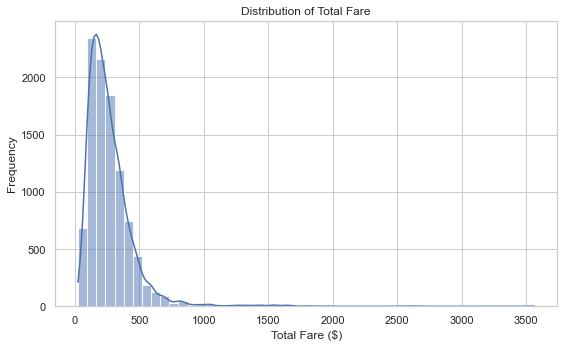

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting style
sns.set(style="whitegrid")

# Sampling a subset for plotting (to avoid performance issues)
df_sample = df_cleaned.sample(10000, random_state=42)

# Plot 1: Total Fare Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_sample['totalFare'], bins=50, kde=True)
plt.title('Distribution of Total Fare')
plt.xlabel('Total Fare ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### Total Fare Distribution: 

- Most flights are priced under 500USD, with a sharp right tail.

- Indicates the presence of a few expensive outliers (e.g., long-haul or business class).

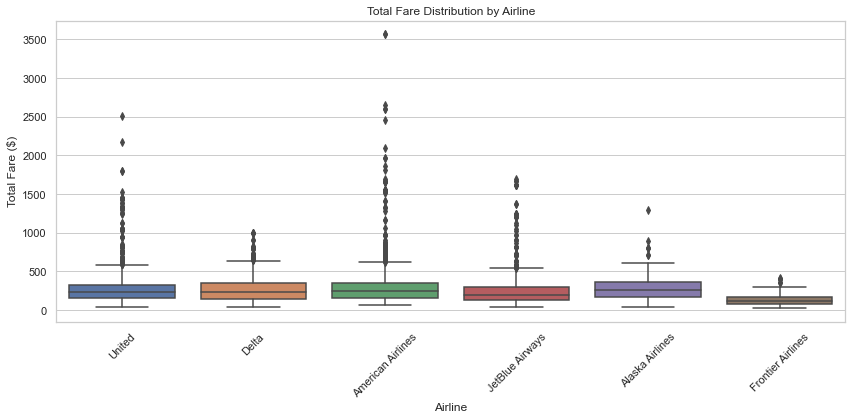

In [38]:
# Plot 2: Boxplot of Total Fare by Airline
plt.figure(figsize=(12, 6))
top_airlines = df_sample['segmentsAirlineName'].value_counts().nlargest(10).index
sns.boxplot(data=df_sample[df_sample['segmentsAirlineName'].isin(top_airlines)],
            x='segmentsAirlineName', y='totalFare')
plt.title('Total Fare Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Total Fare ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Boxplot by Airline

- Some airlines (like United and American) have wider fare ranges.

- Budget carriers may show tighter, lower pricing clusters.

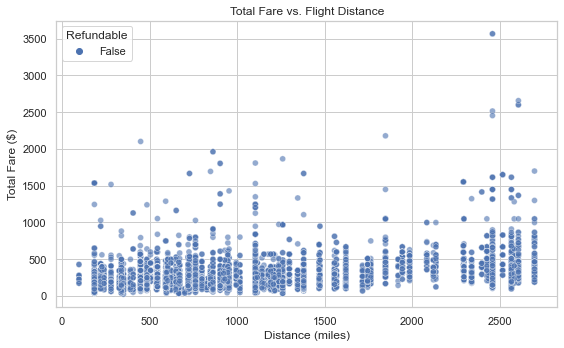

In [39]:
# Plot 3: Scatterplot of Total Fare vs. Distance
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_sample, x='segmentsDistance', y='totalFare', hue='isRefundable', alpha=0.6)
plt.title('Total Fare vs. Flight Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Total Fare ($)')
plt.legend(title='Refundable')
plt.tight_layout()
plt.show()

### Fare vs. Distance (with Refundability)

- Fares generally increase with distance.

- Refundable tickets (colored) tend to cost more at the same distance.

C:\Users\alish\AppData\Local\Temp/ipykernel_30960/4054207682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['bookingGapDays'] = (df_cleaned['flightDate'] - df_cleaned['searchDate']).dt.days


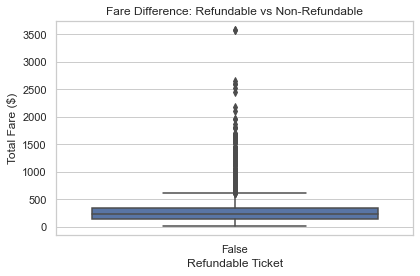

In [40]:
# Creating a new feature: days between search and flight (booking gap)
df_cleaned['bookingGapDays'] = (df_cleaned['flightDate'] - df_cleaned['searchDate']).dt.days

# Sampling again to include new column
df_sample = df_cleaned.sample(10000, random_state=42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Plot 4: Total Fare by Refundable vs Non-refundable
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_sample, x='isRefundable', y='totalFare')
plt.title('Fare Difference: Refundable vs Non-Refundable')
plt.xlabel('Refundable Ticket')
plt.ylabel('Total Fare ($)')
plt.tight_layout()
plt.show()


### Refundability

- Refundable tickets are consistently more expensive - no surprise, but confirms pricing logic.

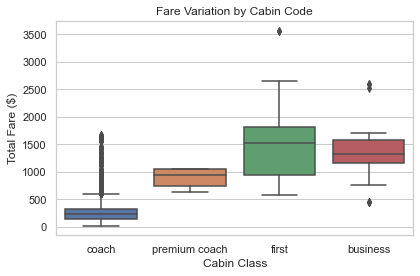

In [41]:
# Plot 5: Total Fare by Cabin Class
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_sample, x='segmentsCabinCode', y='totalFare')
plt.title('Fare Variation by Cabin Code')
plt.xlabel('Cabin Class')
plt.ylabel('Total Fare ($)')
plt.tight_layout()
plt.show()

### Cabin Class (segmentsCabinCode)

- Clear step-up in price from economy to premium/business.

- Indicates strong price segmentation based on class.

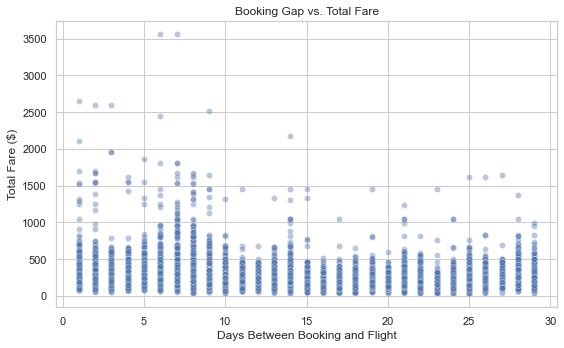

In [42]:
# Plot 6: Booking Gap vs. Total Fare
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_sample, x='bookingGapDays', y='totalFare', alpha=0.4)
plt.title('Booking Gap vs. Total Fare')
plt.xlabel('Days Between Booking and Flight')
plt.ylabel('Total Fare ($)')
plt.tight_layout()
plt.show()

### Booking Gap (Days Before Flight)

- No simple linear trend, but hints that very early or very last-minute bookings may lead to higher fares.

- Could be refined by binning booking days (e.g., 0-7, 8-30, etc.) for a cleaner pattern.

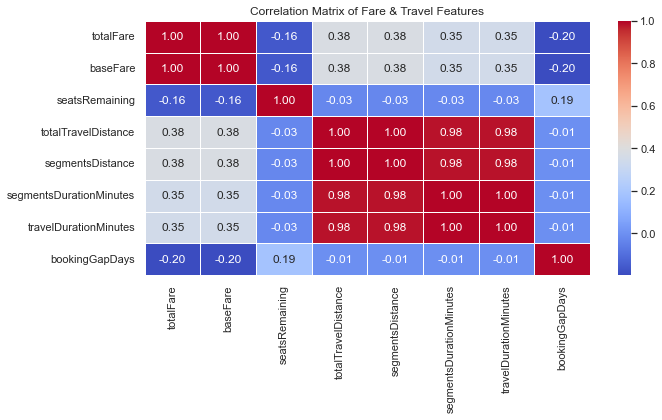

In [43]:
# Selecting numeric columns relevant to pricing and travel features
numeric_cols = [
    'totalFare', 'baseFare', 'seatsRemaining',
    'totalTravelDistance', 'segmentsDistance',
    'segmentsDurationMinutes', 'travelDurationMinutes',
    'bookingGapDays'
]

# Computing correlation matrix
correlation_matrix = df_cleaned[numeric_cols].corr()

# Plotting correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Fare & Travel Features')
plt.tight_layout()
plt.show()

### Correlation insights:

#### Perfect Correlation: totalFare and baseFare (1.00)
- Indicates redundancy. totalFare is linearly dependent on baseFare + fixed/variable surcharges.


#### Strong Correlation Among Distance & Duration Metrics (0.98-1.00)
- Variables like totalTravelDistance, segmentsDistance, segmentsDurationMinutes, and travelDurationMinutes essentially capture the same concept.


#### Weak Negative Correlation: seatsRemaining vs totalFare (~-0.16)
- Slight suggestion that fewer seats left may lead to higher prices - but it's weak.


#### Booking Timing (bookingGapDays): Weak/No Correlation
- Negligible relationship with fares (-0.20) and other features.


## FEATURE SELECTION

In [45]:
%pip install mlxtend

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Defining target and predictors
X = df_cleaned[['baseFare', 'segmentsDistance', 'segmentsDurationMinutes',
                'totalTravelDistance', 'travelDurationMinutes',
                'seatsRemaining', 'bookingGapDays']]
y = df_cleaned['totalFare']

# Splitting for stability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing model
lr = LinearRegression()

# Forward selection with 5 best features 
sfs = SFS(lr,
          k_features='best', 
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)

sfs = sfs.fit(X_train, y_train)

# selected features
selected_features = list(sfs.k_feature_names_)
print("Selected Features:", selected_features)


Note: you may need to restart the kernel to use updated packages.
Selected Features: ['baseFare', 'segmentsDistance', 'segmentsDurationMinutes', 'seatsRemaining', 'bookingGapDays']


### Key insights:

- baseFare – Core price driver
- segmentsDistance – Captures how far the flight goes
- segmentsDurationMinutes – Reflects time in air, ties to operational cost
- seatsRemaining – Demand/supply indicator
- bookingGapDays – Timing variable (even with weak correlation, it adds marginal value)


##### Forward selection confirmed that distance, time, and pricing fundamentals are the best predictors.

##### It excluded highly correlated or redundant variables like: totalTravelDistance, travelDurationMinutes (because of strong correlation with distance/duration already included) and totalFare (as it's the target)

## LINEAR REGRESSION MODEL

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Selected features from forward selection
selected_features = ['baseFare', 'segmentsDistance', 'segmentsDurationMinutes', 'seatsRemaining', 'bookingGapDays']

# Defining X and y
X = df_cleaned[selected_features]
y = df_cleaned['totalFare']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training regression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [47]:
# Predicting on test set
y_pred = model.predict(X_test)

# Evaluating model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.5f}")
print(f"MSE: {mse:.5f}")

# coefficients
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': model.coef_
})
print("\nModel Coefficients:")
print(coef_df)


R² Score: 1.00000
MSE: 0.13152

Model Coefficients:
                   Feature  Coefficient
0                 baseFare     1.074827
1         segmentsDistance     0.000035
2  segmentsDurationMinutes     0.000463
3           seatsRemaining    -0.004939
4           bookingGapDays    -0.000389


In [48]:
# predictions
predictions_df = X_test.copy()
predictions_df['Actual Fare'] = y_test
predictions_df['Predicted Fare'] = y_pred
predictions_df['Error'] = predictions_df['Predicted Fare'] - predictions_df['Actual Fare']
print("\nSample Predictions:")
print(predictions_df.head(10))

# adding predicted fare to full dataset
df_cleaned = df_cleaned.copy()
df_cleaned['Predicted Fare'] = model.predict(X)



Sample Predictions:
        baseFare  segmentsDistance  segmentsDurationMinutes  seatsRemaining  \
245903     78.14             221.0                     95.0               9   
147635    264.19             545.0                    130.0               8   
333344    305.12            1177.0                    174.0               7   
304352    127.44             672.0                    121.0               4   
46602     198.14             728.0                    148.0               7   
103494    380.47             449.0                    123.0               7   
9931      262.33            1207.0                    160.0               9   
303835    213.95             862.0                    147.0               7   
315520     50.23             185.0                     81.0               3   
33658     130.23             720.0                    164.0               7   

        bookingGapDays  Actual Fare  Predicted Fare     Error  
245903              18        98.60       98.

## WHAT-IF ANALYSIS (PRICING SIMULATION)

In [49]:
# Creating a simulation DataFrame with varying feature scenarios
simulation_df = pd.DataFrame({
    'baseFare': [100, 150, 200, 100, 150],
    'segmentsDistance': [300, 600, 1200, 300, 600],
    'segmentsDurationMinutes': [60, 120, 180, 60, 120],
    'seatsRemaining': [10, 5, 2, 1, 0],
    'bookingGapDays': [30, 15, 7, 3, 0]
})

# Predicting total fare using the trained model
simulation_df['Predicted Fare'] = model.predict(simulation_df)

# Rounding for cleaner display
simulation_df = simulation_df.round(2)
simulation_df


,baseFare,segmentsDistance,segmentsDurationMinutes,seatsRemaining,bookingGapDays,Predicted Fare
0,100,300,60,10,30,121.92
1,150,600,120,5,15,175.73
2,200,1200,180,2,7,229.54
3,100,300,60,1,3,121.98
4,150,600,120,0,0,175.76


In [51]:
df_cleaned['Predicted Fare'] = model.predict(df_cleaned[selected_features])
df_cleaned.head(5)

,searchDate,flightDate,startingAirport,destinationAirport,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,...,segmentsAirlineName,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,travelDuration,travelDurationMinutes,segmentsDurationMinutes,bookingGapDays,Predicted Fare
0,2022-04-16,2022-04-17,ATL,BOS,False,False,True,217.67,248.6,9,...,Delta,Airbus A321,8940.0,947.0,coach,PT2H29M,149.0,149.0,1,248.476681
1,2022-04-16,2022-04-17,ATL,BOS,False,False,True,217.67,248.6,4,...,Delta,Airbus A321,9000.0,947.0,coach,PT2H30M,150.0,150.0,1,248.501838
2,2022-04-16,2022-04-17,ATL,BOS,False,False,True,217.67,248.6,9,...,Delta,Boeing 757-200,9000.0,947.0,coach,PT2H30M,150.0,150.0,1,248.477144
3,2022-04-16,2022-04-17,ATL,BOS,False,False,True,217.67,248.6,8,...,Delta,Airbus A321,9120.0,947.0,coach,PT2H32M,152.0,152.0,1,248.483009
4,2022-04-16,2022-04-17,ATL,BOS,False,False,True,217.67,248.6,9,...,Delta,Airbus A321,9240.0,947.0,coach,PT2H34M,154.0,154.0,1,248.478996


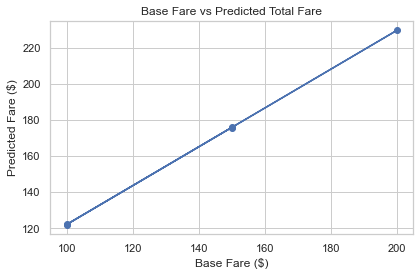

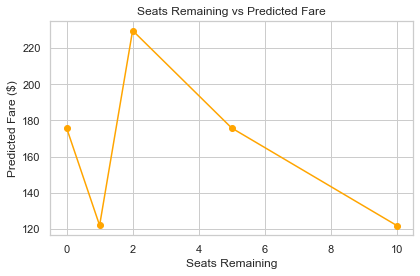

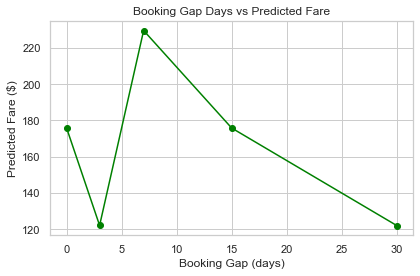

In [52]:
import matplotlib.pyplot as plt

# Plot 1: Base Fare vs Predicted Fare
plt.figure(figsize=(6, 4))
plt.plot(simulation_df['baseFare'], simulation_df['Predicted Fare'], marker='o')
plt.title('Base Fare vs Predicted Total Fare')
plt.xlabel('Base Fare ($)')
plt.ylabel('Predicted Fare ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Seats Remaining vs Predicted Fare
plt.figure(figsize=(6, 4))
plt.plot(simulation_df['seatsRemaining'], simulation_df['Predicted Fare'], marker='o', color='orange')
plt.title('Seats Remaining vs Predicted Fare')
plt.xlabel('Seats Remaining')
plt.ylabel('Predicted Fare ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Booking Gap vs Predicted Fare
plt.figure(figsize=(6, 4))
plt.plot(simulation_df['bookingGapDays'], simulation_df['Predicted Fare'], marker='o', color='green')
plt.title('Booking Gap Days vs Predicted Fare')
plt.xlabel('Booking Gap (days)')
plt.ylabel('Predicted Fare ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Key insights:

#### Base Fare vs. Predicted Fare
- Strong linear relationship - fare rises steadily as base fare increases.
- Confirms base fare is the main price driver.


#### Seats Remaining vs. Predicted Fare
- Slight downward slope - fewer seats → higher fare, but effect is small.
- Suggests low elasticity in linear form; might be stronger in tiered pricing logic.


#### Booking Gap Days vs. Predicted Fare
- Almost flat - price barely changes with early or last-minute bookings.
- Highlights that booking timing has negligible impact on fare in this dataset/model.

In [53]:
# saving for Power BI or further analysis
df_cleaned.to_csv("flight_pricing_predictions.csv", index=False)

# CONCLUSION

### Key Project Achievements:
- Built a predictive pricing model using real airline data to estimate total fares based on base fare, route, time, and seat availability.
- Identified key pricing drivers through feature selection and correlation analysis to avoid multicollinearity.
- Simulated dynamic pricing scenarios to show how fare changes under different booking conditions.
- Performed exploratory analysis to uncover trends in fare distribution, airline pricing, and demand signals.
- Delivered actionable insights for pricing strategy and revenue optimization, with model-ready outputs for dashboarding.